# Step by Step Guide to Building the IR-ML Model
Note that the main code has been created as an object oriented program in Python as well.

### 1. Read in the Data (and import libraries)


In [ ]:
import csv
import math
import numpy as np
import pandas as pd
import shap
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

csv_file = pd.read_csv('Full_File.csv', index_col=0)
df = pd.DataFrame(csv_file)
X = df.drop(['CH', 'C=C', 'C≡C', 'C≡N', 'C-OH','C=O', 'C=OOH', 'N-H', 'C≡C-H'], axis=1)
y = df[['CH','C=C','C≡C', 'C≡N', 'C-OH','C=O', 'C=OOH', 'N-H', 'C≡C-H']]
print(len(df))

101


### Calculate Class Representation in the Dataset


Text(0, 0.5, 'Count')

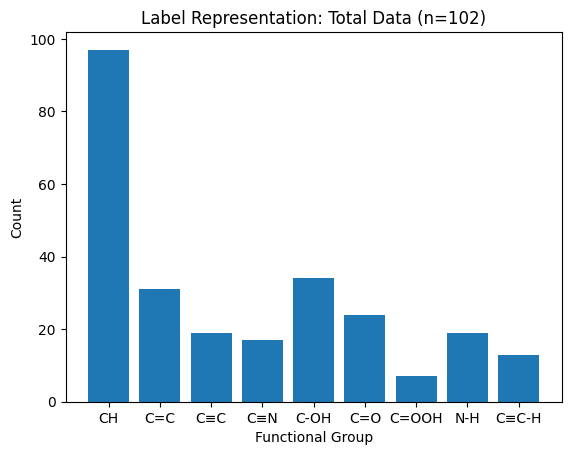

In [84]:
# get 
OH = y['C-OH'].value_counts()[1]
CH = y['CH'].value_counts()[1]
C_C_db = y['C=C'].value_counts()[1]
C_C_tb = y['C≡C'].value_counts()[1]
C_N = y['C≡N'].value_counts()[1]
CO = y['C=O'].value_counts()[1]
C_OOH = y['C=OOH'].value_counts()[1]
NH = y['N-H'].value_counts()[1]
CCH = y['C≡C-H'].value_counts()[1]
x_label = ['CH','C=C','C≡C', 'C≡N', 'C-OH','C=O', 'C=OOH', 'N-H', 'C≡C-H']
y_n = [CH, C_C_db, C_C_tb, C_N, OH, CO, C_OOH, NH, CCH]
plt.bar(x_label, y_n)
plt.title('Label Representation: Total Data (n=102)')
plt.xlabel('Functional Group')
plt.ylabel('Count')

### 2. Split Data into Train Test and Validation

In [72]:
mskf = MultilabelStratifiedKFold(n_splits=7, shuffle=True, random_state=42)
for train_idx, test_idx in mskf.split(X, y):
    X_temp, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_temp, y_test = y.iloc[train_idx], y.iloc[test_idx]
    break
for t_idx, val_idx in mskf.split(X_temp, y_temp):
    X_train, X_val = X_temp.iloc[t_idx], X_temp.iloc[val_idx]
    y_train, y_val = y_temp.iloc[t_idx], y_temp.iloc[val_idx]
    break


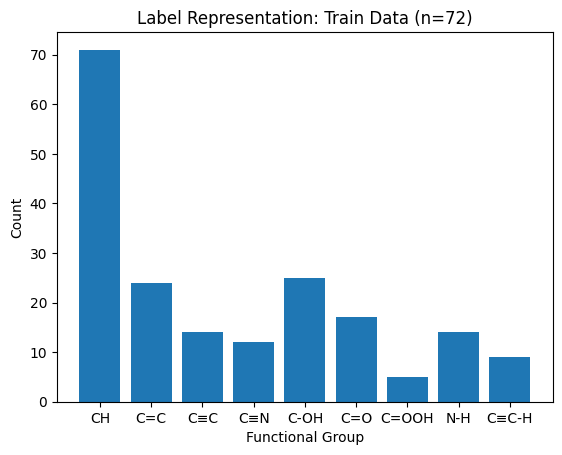

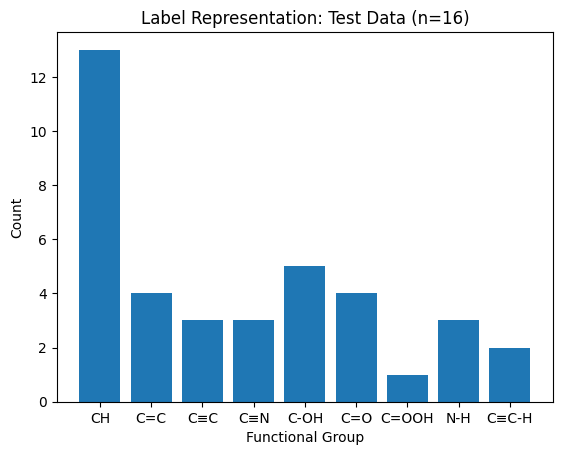

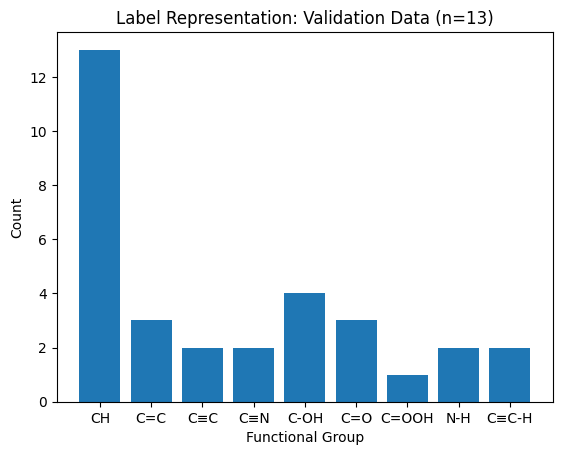

In [83]:
#Calculate Data representation in train/test/validation data
def plot_data(y_test, label):
    OH = y_test['C-OH'].value_counts()[1]
    CH = y_test['CH'].value_counts()[1]
    C_C_db = y_test['C=C'].value_counts()[1]
    C_C_tb = y_test['C≡C'].value_counts()[1]
    C_N = y_test['C≡N'].value_counts()[1]
    CO = y_test['C=O'].value_counts()[1]
    C_OOH = y_test['C=OOH'].value_counts()[1]
    NH = y_test['N-H'].value_counts()[1]
    CCH = y_test['C≡C-H'].value_counts()[1]
    x_label = ['CH','C=C','C≡C', 'C≡N', 'C-OH','C=O', 'C=OOH', 'N-H', 'C≡C-H']
    y_n = [CH, C_C_db, C_C_tb, C_N, OH, CO, C_OOH, NH, CCH]
    plt.bar(x_label, y_n)
    plt.title(label)
    plt.xlabel('Functional Group')
    plt.ylabel('Count')
    plt.show()
train_plot = plot_data(y_train, "Label Representation: Train Data (n=72)")
test_pot = plot_data(y_test, "Label Representation: Test Data (n=16)")
val_pot = plot_data(y_val, "Label Representation: Validation Data (n=13)")

# 3. Fit KNN Model and Evaluate Performance

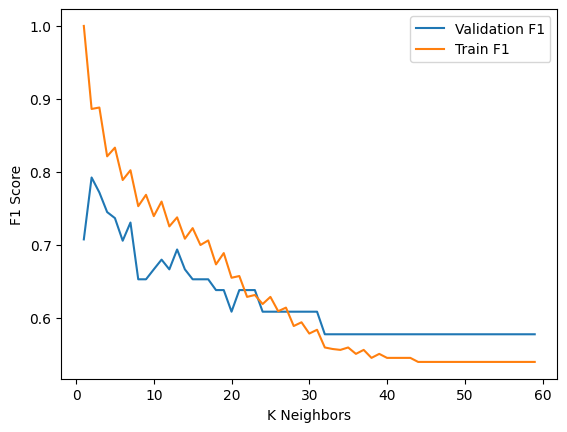

Best K : 2


In [6]:
test_accuracy=[]
train_accuracy = []
kl=[]
for k in range(1,60):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_train_pred = neigh.predict(X_train)
    y_val_pred = neigh.predict(X_val)
    train_accuracy.append(f1_score(y_train, y_train_pred, average='micro'))
    test_accuracy.append(f1_score(y_val, y_val_pred, average='micro'))
    kl.append(k)
plt.plot(kl, test_accuracy, label='Validation F1')
plt.plot(kl, train_accuracy, label='Train F1')
plt.xlabel('K Neighbors')
plt.ylabel('F1 Score')
plt.legend()
plt.show()
best_k = kl[test_accuracy.index(max(test_accuracy))]
print('Best K :', best_k)
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train, y_train)
y_train_pred = neigh.predict(X_train)
y_val_pred = neigh.predict(X_val)

# 4. Fit Decision Tree Model and Evaluate Performance

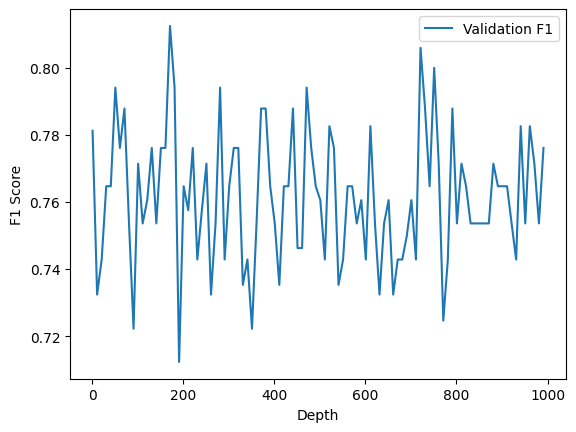

Best Tree Depth:  180


In [7]:
scores = []
dl = []
for d in range(1,1000, 10):
    Decision_Tree = OneVsRestClassifier(DecisionTreeClassifier(max_depth=d))
    Decision_Tree.fit(X_train, y_train)
    y_pred = Decision_Tree.predict(X_val)
    scores.append(f1_score(y_val, y_pred, average='micro'))
    dl.append(d)
plt.plot(dl, scores, label='Validation F1')
plt.xlabel('Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.show()
best_score = max(scores)
best_depth = (scores.index(best_score)+1)*10
Decision_Tree = OneVsRestClassifier(DecisionTreeClassifier(max_depth=best_depth))
Decision_Tree.fit(X_train, y_train)
y_pred = Decision_Tree.predict(X_val)
print('Best Tree Depth: ', best_depth)

# 5. Fit Random Forest Model and Evaluate Performance

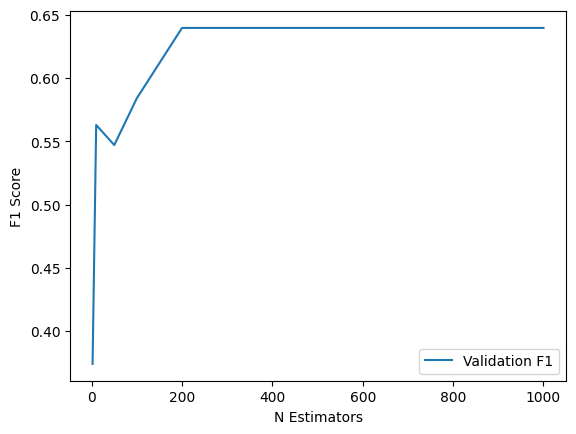

Best N Estimators: 200


In [8]:
n_estimators = [2,10,50,100,200,300,400,500,600,700,800,900,1000]
scores = []
for n in n_estimators:
    clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=n, class_weight='balanced', random_state=42))
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    score = f1_score(y_val, y_val_pred, average='macro')
    scores.append(score)
plt.plot(n_estimators, scores, label='Validation F1')
plt.xlabel('N Estimators')
plt.ylabel('F1 Score')
plt.legend()
plt.show()
best_score = max(scores)
best_n = n_estimators[scores.index(best_score)]
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=best_n, class_weight='balanced', random_state=42))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print('Best N Estimators:', best_n)

# 6. Fit RBF SVC

Done


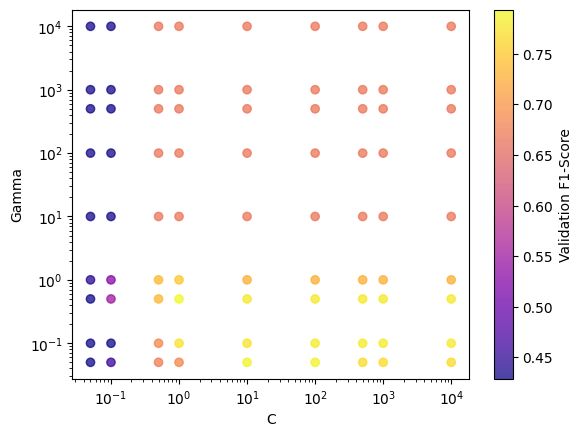

Best C 1
Best Gamma 0.5


In [9]:
c_grid = [0.05,0.1,0.5,1,10,100,500,1000,10000]
gamma_grid = [0.05, 0.1,0.5,1,10,100,500,1000,10000]
preds_micro = []
cl = []
gl = []
for c in c_grid:
    pred_c_micro = []
    pred_c_macro = []
    for gamma in gamma_grid:
        cl.append(c)
        gl.append(gamma)
        SVC_rbf = OneVsRestClassifier(SVC(C=c, gamma=gamma, kernel='rbf', class_weight="balanced"))
        SVC_rbf.fit(X_train, y_train)
        y_pred = SVC_rbf.predict(X_val)
        pred_c_macro.append(f1_score(y_val, y_pred, average='macro'))
        pred_c_micro.append(f1_score(y_val, y_pred, average='micro'))
    preds_micro.append(pred_c_micro)
plt.scatter(cl, gl, label='Test F1', cmap='plasma', c=preds_micro,alpha=0.75)
plt.colorbar(label='Validation F1-Score')

print('Done')
plt.xlabel('C')
plt.ylabel('Gamma')
plt.xscale('log')
plt.yscale('log')
plt.show()
preds_micro = np.array(preds_micro)
best_score = np.max(preds_micro)
row = np.where(preds_micro==best_score)[0][0]
col = np.where(preds_micro==best_score)[1][0]
best_c = c_grid[row]
best_gamma = gamma_grid[col]
SVC_rbf= OneVsRestClassifier(SVC(kernel='rbf', C=best_c, gamma=best_gamma, class_weight='balanced'))
SVC_rbf.fit(X_train, y_train)
y_pred = SVC_rbf.predict(X_val)
print('Best C', best_c)
print('Best Gamma', best_gamma)


# 7. Fit Linear SVC

Done


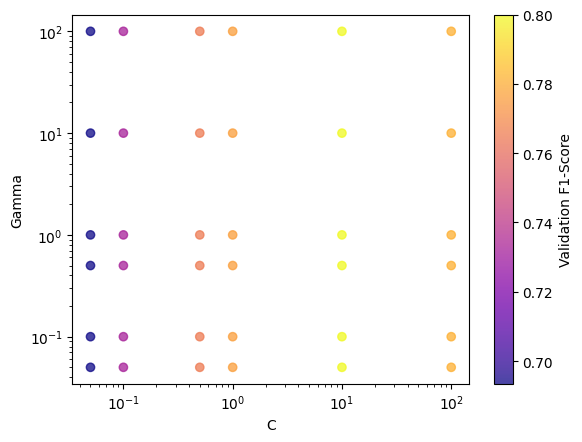

Best C 10
Best Gamma 0.05


In [10]:
#this one takes a while to run
c_grid = [0.05, 0.1, 0.5, 1, 10, 100]
gamma_grid = [0.05, 0.1, 0.5, 1, 10, 100]
preds_micro = []
cl = []
gl = []
for c in c_grid:
    pred_c_micro = []
    pred_c_macro = []
    for gamma in gamma_grid:
        cl.append(c)
        gl.append(gamma)
        SVC_lin = OneVsRestClassifier(SVC(C=c, gamma=gamma, kernel='linear', class_weight="balanced"))
        SVC_lin.fit(X_train, y_train)
        y_pred = SVC_lin.predict(X_val)
        pred_c_macro.append(f1_score(y_val, y_pred, average='macro'))
        pred_c_micro.append(f1_score(y_val, y_pred, average='micro'))
    preds_micro.append(pred_c_micro)
plt.scatter(cl, gl, cmap='plasma', c=preds_micro,alpha=0.75)
plt.colorbar(label='Validation F1-Score')
print('Done')
plt.xlabel('C')
plt.ylabel('Gamma')
plt.xscale('log')
plt.yscale('log')
plt.show()
preds_micro = np.array(preds_micro)
best_score = np.max(preds_micro)
row = np.where(preds_micro==best_score)[0][0]
col = np.where(preds_micro==best_score)[1][0]
best_c = c_grid[row]
best_gamma = gamma_grid[col]
SVC_lin= OneVsRestClassifier(SVC(kernel='linear', C=best_c, gamma=best_gamma,class_weight='balanced' ))
SVC_lin.fit(X_train, y_train)
y_pred = SVC_lin.predict(X_val)
print('Best C', best_c)
print('Best Gamma', best_gamma)

# 8. Fit Logistic Regression Model and Evaluate Performance

In [11]:
reg = LogisticRegression(solver='liblinear', C=1, class_weight='balanced', max_iter=1000, penalty='l2')
multi_label = OneVsRestClassifier(reg)
multi_label.fit(X_train, y_train)
y_val_pred = multi_label.predict(X_val)

# 9. Generate Test Data Performance Metrics for all models

In [65]:
#Calculated Train/Val/Test Performance
md_table = pd.DataFrame() 
def metrics(model, name, X_val, y_true):
    y_pred = model.predict(X_val)
    print('Macro F1', name, ' :', f1_score(y_true, y_pred, average='macro'))
    print('Micro F1 ', name, ': ', f1_score(y_true, y_pred, average='micro'))
    print('Accuracy Score ', name,':', accuracy_score(y_true, y_pred))       
    print(classification_report(y_true, y_pred, target_names=['CH', 'C=C', 'C≡C', 'C≡N', 'C-OH', 'C=O', 'C=OOH', 'N-H', 'C≡C-H'], output_dict=False))
#Train Performance 
metrics(multi_label, 'Logistic Regression', X_train, y_train)
metrics(Decision_Tree, 'Decision Tree', X_train, y_train)
metrics(clf, 'Random Forest', X_train, y_train)
metrics(SVC_lin, 'Linear SVC', X_train, y_train)
metrics(SVC_rbf, 'RBF SVC', X_train, y_train)
metrics(neigh, 'KNN', X_train, y_train)

Macro F1 Logistic Regression  : 0.8683723302483505
Micro F1  Logistic Regression :  0.9108910891089109
Accuracy Score  Logistic Regression : 0.5694444444444444
              precision    recall  f1-score   support

          CH       1.00      0.99      0.99        71
         C=C       0.78      0.88      0.82        24
         C≡C       0.76      0.93      0.84        14
         C≡N       0.60      1.00      0.75        12
        C-OH       0.96      0.92      0.94        25
         C=O       0.94      1.00      0.97        17
       C=OOH       0.50      1.00      0.67         5
         N-H       0.88      1.00      0.93        14
       C≡C-H       0.82      1.00      0.90         9

   micro avg       0.86      0.96      0.91       191
   macro avg       0.80      0.97      0.87       191
weighted avg       0.89      0.96      0.92       191
 samples avg       0.87      0.96      0.90       191

Macro F1 Decision Tree  : 1.0
Micro F1  Decision Tree :  1.0
Accuracy Score  Deci

In [67]:
#Validation Data
metrics(multi_label, 'Logistic Regression', X_val, y_val)
metrics(Decision_Tree, 'Decision Tree',   X_val, y_val)
metrics(clf, 'Random Forest',   X_val, y_val)
metrics(SVC_lin, 'Linear SVC',   X_val, y_val)
metrics(SVC_rbf, 'RBF SVC',  X_val, y_val)
metrics(neigh, 'KNN',   X_val, y_val)

Macro F1 Logistic Regression  : 0.6853615520282186
Micro F1  Logistic Regression :  0.782608695652174
Accuracy Score  Logistic Regression : 0.3076923076923077
              precision    recall  f1-score   support

          CH       1.00      1.00      1.00        13
         C=C       0.67      0.67      0.67         3
         C≡C       0.67      1.00      0.80         2
         C≡N       0.29      1.00      0.44         2
        C-OH       1.00      0.25      0.40         4
         C=O       0.75      1.00      0.86         3
       C=OOH       0.00      0.00      0.00         1
         N-H       1.00      1.00      1.00         2
       C≡C-H       1.00      1.00      1.00         2

   micro avg       0.73      0.84      0.78        32
   macro avg       0.71      0.77      0.69        32
weighted avg       0.85      0.84      0.80        32
 samples avg       0.74      0.85      0.77        32

Macro F1 Decision Tree  : 0.6384126984126984
Micro F1  Decision Tree :  0.74626865

/Users/bwclark/opt/anaconda3/envs/DS_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/bwclark/opt/anaconda3/envs/DS_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [66]:
# Test Data 
metrics(multi_label, 'Logistic Regression', X_test, y_test)
metrics(Decision_Tree, 'Decision Tree',  X_test, y_test)
metrics(clf, 'Random Forest',  X_test, y_test)
metrics(SVC_lin, 'Linear SVC',  X_test, y_test)
metrics(SVC_rbf, 'RBF SVC',  X_test, y_test)
metrics(neigh, 'KNN',  X_test, y_test)

Macro F1 Logistic Regression  : 0.6411512497719394
Micro F1  Logistic Regression :  0.7126436781609196
Accuracy Score  Logistic Regression : 0.1875
              precision    recall  f1-score   support

          CH       0.81      1.00      0.90        13
         C=C       0.75      0.75      0.75         4
         C≡C       1.00      1.00      1.00         3
         C≡N       0.11      0.33      0.17         3
        C-OH       0.80      0.80      0.80         5
         C=O       1.00      0.75      0.86         4
       C=OOH       0.00      0.00      0.00         1
         N-H       0.40      0.67      0.50         3
       C≡C-H       0.67      1.00      0.80         2

   micro avg       0.63      0.82      0.71        38
   macro avg       0.62      0.70      0.64        38
weighted avg       0.72      0.82      0.75        38
 samples avg       0.65      0.86      0.71        38

Macro F1 Decision Tree  : 0.6175805675805676
Micro F1  Decision Tree :  0.7209302325581395
Ac

/Users/bwclark/opt/anaconda3/envs/DS_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/bwclark/opt/anaconda3/envs/DS_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/bwclark/opt/anaconda3/envs/DS_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

## 10. Calculate Confusion Matrices for Different Models and Labels

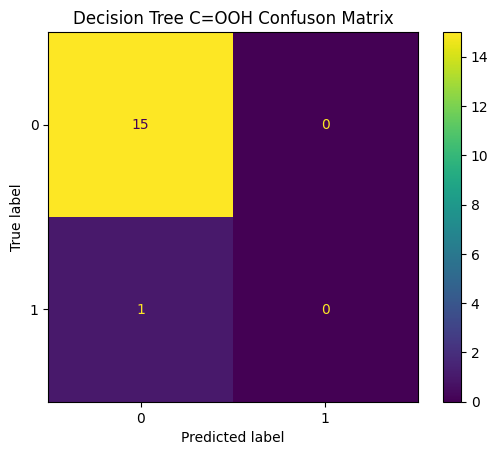

In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
funct_dict = {'CH':0, 'C=C':1, 'C≡C':2, 'C≡N':3, 'C-OH':4, 'C=O':5, 'C=OOH':6, 'N-H':7, 'C≡C-H':8}

def cm(model, name, funct_group):
    y_pred = model.predict(X_test)
    ch_pred = y_pred[:,funct_dict[funct_group]]
    ch_test = y_test[funct_group]
    cm = confusion_matrix(ch_test, ch_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.title(name + ' ' + funct_group + ' Confuson Matrix')
cm(clf, 'Decision Tree', 'C=OOH')

## 11. Interpretation with Random Forest Importance Scores

Random Forest Fx Group: ['CH', 'C=O', 'N-H']
Correct Fx Group: ['CH', 'C=O', 'N-H'] 



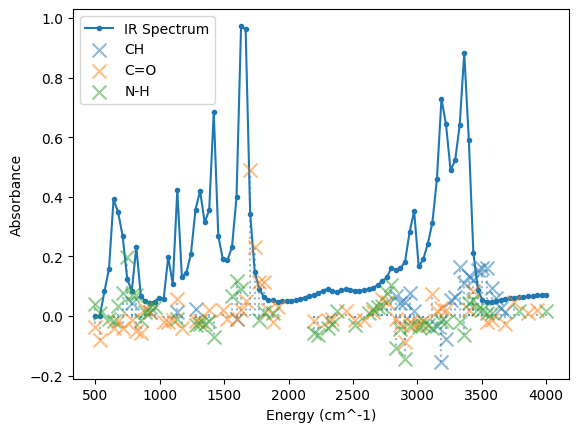

In [63]:
def predict_rf(name): 
    wave_numbers = X.columns.astype(float)
    funct_d = {'CH':0,'C=C':1,'C≡C':2, 'C≡N':3, 'C-OH':4,'C=O':5, 'C=OOH':6, 'N-H':7, 'C≡C-H':8}
    functionals = ['CH','C=C','C≡C', 'C≡N', 'C-OH','C=O', 'C=OOH', 'N-H', 'C≡C-H']
    df_hex = pd.DataFrame(X.loc[name]).T
    random_forest_pred = clf.predict(df_hex)
    rf_l = []
    correct = y.loc[name].T
    cr_l = []
    for funct, rf, cr in zip(functionals, random_forest_pred[0], correct):
        if rf == 1:
            rf_l.append(funct)
        if cr == 1:
            cr_l.append(funct)
    print('Random Forest Fx Group:', rf_l)
    print('Correct Fx Group:', cr_l, '\n')
    fig, ax = plt.subplots()
    ax.plot(wave_numbers, df_hex.values[0], label='IR Spectrum', alpha=1, marker='.')
    for k in rf_l:
        explainer = shap.TreeExplainer(clf.estimators_[funct_d[k]])
        shap_values = explainer.shap_values(df_hex)*5
        wave_numbers_shap = list(wave_numbers)
        of_interest = list(shap_values[0,:,1])
        for i in shap_values[0,:,1]:
            if abs(i) < 0.01:
                del wave_numbers_shap[of_interest.index(i)]
                of_interest.remove(i)
        ax.scatter(wave_numbers_shap, of_interest, label=k, alpha=0.5, marker='x', s=100, zorder=2)
        ax.vlines(x=wave_numbers_shap, ymax=of_interest, ymin=0, linestyles='dotted', alpha=0.5, zorder=1)
    plt.legend()
    plt.ylabel('Absorbance')
    plt.xlabel('Energy (cm^-1)')
    plt.show()

predict_rf('propanamide')